In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install geemap
!pip install geopandas
!pip install rasterio
!pip install rasterio geopandas scikit-learn matplotlib seaborn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 48.8 MB/s eta 0:00:00


# Step 1: Upload the multiband GeoTIFF image and training data GeoPackage to Google Colab (or mount your Google Drive folder)

In [11]:
import geopandas as gpd
import ee
import geemap
import os
# Import necessary libraries
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
import geopandas as gpd
from sklearn.ensemble import RandomForestClassifier
#from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

# Step 2: Read the multiband tiff image

In [12]:
import rasterio
import numpy as np

# Load the 2017 image
with rasterio.open('/content/drive/MyDrive/EarthEngine/Sentinel2_2017.tif') as src_2017:
    img_2017 = src_2017.read()
    img_2017 = img_2017.astype('float32') / 10000
    img_2017 = np.nan_to_num(img_2017, nan=0.0)

# Load the 2024 image
print("2017 image loaded.")
#with rasterio.open('/content/drive/MyDrive/EarthEngine/Sentinel2_2024.tif') as src_2024:
with rasterio.open('/content/drive/MyDrive/EarthEngine/Sentinel2_2024_matched.tif') as src_2024:
    img_2024 = src_2024.read()
    img_2024 = img_2024.astype('float32') / 10000
    img_2024 = np.nan_to_num(img_2024, nan=0.0)
print("2024 image loaded.")

print(img_2017.shape)
print(img_2024.shape)



2017 image loaded.
2024 image loaded.
(10, 2276, 2346)
(10, 2276, 2346)


# Step 3: Read the vector training areas from GeoPackage

In [13]:
import rasterio
import numpy as np

def load_and_normalize_image(image_path):
    with rasterio.open(image_path) as src:
        img = src.read()
        img = np.nan_to_num(img, nan=0.0)  # Replace NaN values with 0
        img = img.astype('float32')

        # Min-max normalization for each band
        for i in range(img.shape[0]):
            band_min = img[i].min()
            band_max = img[i].max()
            img[i] = (img[i] - band_min) / (band_max - band_min)

        transform = src.transform
        crs = src.crs
    return img, transform, crs

# Load and normalize the 2017 image
img_2017, transform_2017, crs_2017 = load_and_normalize_image('/content/drive/My Drive/EarthEngine/Sentinel2_2017.tif')
print(f"2017 Image: min={np.min(img_2017)}, max={np.max(img_2017)}, mean={np.mean(img_2017)}")

# Load and normalize the 2024 image
img_2024, transform_2024, crs_2024 = load_and_normalize_image('/content/drive/My Drive/EarthEngine/Sentinel2_2024_matched.tif')
print(f"2024 Image: min={np.min(img_2024)}, max={np.max(img_2024)}, mean={np.mean(img_2024)}")


2017 Image: min=0.0, max=1.0, mean=0.10090185701847076
2024 Image: min=0.0, max=1.0, mean=0.10090229660272598


# Step 4: Extract pixel values from the image (X) corresponding to training data (y)

In [14]:
# Path to the labeled shapefile
geopackage_path = '/content/drive/MyDrive/EO/ROI/ROI.gpkg'

# Read the labeled GeoPackage file
labeled_gdf = gpd.read_file(geopackage_path)

# Ensure the GeoDataFrame is in the correct projection (WGS84)
labeled_gdf = labeled_gdf.to_crs(epsg=4326)

# Filter out rows with None or empty geometries
labeled_gdf = labeled_gdf[~labeled_gdf.is_empty]

# Display the first few rows to check the data
print(labeled_gdf.head())

   id                                           geometry
0   1  MULTIPOLYGON (((-77.03866 38.88618, -77.03805 ...
1   1  MULTIPOLYGON (((-77.02163 38.87070, -77.01883 ...
2   1  MULTIPOLYGON (((-76.97956 38.87717, -76.97760 ...
4   1  MULTIPOLYGON (((-77.01381 38.89032, -77.01338 ...
5   1  MULTIPOLYGON (((-77.04157 38.88946, -77.04162 ...


# Step 5: Split data into training and testing sets

In [15]:
import rasterio.features
import geopandas as gpd

# Function to ensure geometries are valid and have the correct CRS
def preprocess_geometries(labeled_gdf, target_crs):
    labeled_gdf = labeled_gdf[labeled_gdf['geometry'].notnull()]
    labeled_gdf = labeled_gdf[labeled_gdf.is_valid]
    if labeled_gdf.crs != target_crs:
        labeled_gdf = labeled_gdf.to_crs(target_crs)
    return labeled_gdf

# Function to extract training data
def extract_training_data(image, labeled_gdf, transform, num_samples_per_class=500):
    X = []
    y = []
    for index, row in labeled_gdf.iterrows():
        geom = [row['geometry']]  # Geometry must be a sequence
        label = row['id']  # Adjust the column name to reflect your label column

        # Create a mask for the polygon
        mask = rasterio.features.geometry_mask(geom, transform=transform, invert=True, out_shape=(image.shape[1], image.shape[2]))

        # Extract pixel values within the polygon
        pixels = np.column_stack([np.ma.masked_array(image[band], mask=~mask).compressed() for band in range(image.shape[0])])

        # Randomly sample a subset of pixels if there are too many
        #if pixels.shape[0] > num_samples_per_class:
        #    indices = np.random.choice(pixels.shape[0], num_samples_per_class, replace=False)
        #    pixels = pixels[indices]

        X.extend(pixels)
        y.extend([label] * pixels.shape[0])

    return np.array(X), np.array(y)

# Preprocess geometries
#target_crs = rasterio.open('/content/drive/My Drive/EarthEngine/Sentinel2_2024.tif').crs
#labeled_gdf = preprocess_geometries(labeled_gdf, target_crs)

# Extract training data from the 2017 image
X_train, y_train = extract_training_data(img_2017, labeled_gdf, transform_2017)

print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")

Training data shape: (34356, 10)
Training labels shape: (34356,)


# Step 6: Train a MLP classifier

Iteration 1, loss = 0.89576173
Iteration 2, loss = 0.30689535
Iteration 3, loss = 0.18578277
Iteration 4, loss = 0.15298189
Iteration 5, loss = 0.13799517
Iteration 6, loss = 0.12738813
Iteration 7, loss = 0.12050196
Iteration 8, loss = 0.11579919
Iteration 9, loss = 0.10955052
Iteration 10, loss = 0.10620307
Iteration 11, loss = 0.10319123
Iteration 12, loss = 0.10121101
Iteration 13, loss = 0.09873752
Iteration 14, loss = 0.09643256
Iteration 15, loss = 0.09399232
Iteration 16, loss = 0.09202306
Iteration 17, loss = 0.09114033
Iteration 18, loss = 0.09043699
Iteration 19, loss = 0.08834956
Iteration 20, loss = 0.08796304
Iteration 21, loss = 0.08746514
Iteration 22, loss = 0.08555011
Iteration 23, loss = 0.08385437
Iteration 24, loss = 0.08492018
Iteration 25, loss = 0.08239102
Iteration 26, loss = 0.08314306
Iteration 27, loss = 0.08047304
Iteration 28, loss = 0.07957809
Iteration 29, loss = 0.07917601
Iteration 30, loss = 0.07835536
Iteration 31, loss = 0.07889926
Iteration 32, los

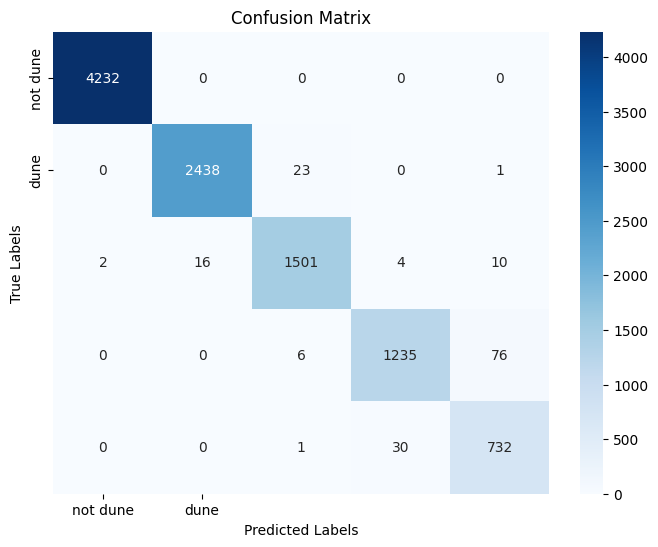

In [16]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

# Define the MLP model
mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=300, alpha=1e-4,
                    solver='adam', verbose=5, tol=1e-4, random_state=1,
                    learning_rate_init=.001)

# Train the model
mlp.fit(X_train_split, y_train_split)

# Evaluate the model
y_pred_split = mlp.predict(X_test_split)
print("Classification report for test data:")
print(classification_report(y_test_split, y_pred_split))


# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_split, y_pred_split)
custom_labels = ['not dune', 'dune'] # {1:'not_dune', 2:'dune'}

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=custom_labels,
            yticklabels=custom_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()




# Step 7: Evaluate the classifier

In [9]:
# Reshape the 2017 image data to (n_samples, n_features)
n_samples = img_2017.shape[1] * img_2017.shape[2]
X_2017 = img_2017.reshape((img_2017.shape[0], n_samples)).T

# Predict the land cover and land use for 2017
y_pred_2017 = mlp.predict(X_2017)

# Reshape the predictions back to the original image shape
y_pred_2017_img = y_pred_2017.reshape((img_2017.shape[1], img_2017.shape[2]))

# Save the classification result as a new GeoTIFF
#with rasterio.open('/content/drive/My Drive/EarthEngine/RF_2024_LCLU.tif', 'w', driver='GTiff',
#                   height=img_2017.shape[1], width=img_2017.shape[2], count=1, dtype=y_pred_2017_img.dtype,
#                   crs=src_2024.crs, transform=src_2024.transform) as dst:
#    dst.write(y_pred_2017_img, 1)

In [ ]:
# Reshape the 2024 image data to (n_samples, n_features)
n_samples = img_2024.shape[1] * img_2024.shape[2]
X_2024 = img_2024.reshape((img_2024.shape[0], n_samples)).T
#X_2024 = np.nan_to_num(X_2024, nan=0.0)

# Predict the land cover and land use for 2024
y_pred_2024 = mlp.predict(X_2024)

# Reshape the predictions back to the original image shape
y_pred_2024_img = y_pred_2024.reshape((img_2024.shape[1], img_2024.shape[2]))

# Save the classification result as a new GeoTIFF
#with rasterio.open('/content/drive/My Drive/EarthEngine/RF_2024_LCLU.tif', 'w', driver='GTiff',
#                   height=img_2024.shape[1], width=img_2024.shape[2], count=1, dtype=y_pred_2024_img.dtype,
#                   crs=src_2024.crs, transform=src_2024.transform) as dst:
#    dst.write(y_pred_2024_img, 1)


In [ ]:
import matplotlib.pyplot as plt

# Visualize the classification result for 2017
plt.figure(figsize=(10, 10))
plt.title("Land Cover and Land Use Classification for 2017")
plt.imshow(y_pred_2017_img, cmap='tab10')
plt.colorbar()
plt.show()

# Visualize the classification result for 2024
plt.figure(figsize=(10, 10))
plt.title("Land Cover and Land Use Classification for 2024")
plt.imshow(y_pred_2024_img, cmap='tab10')
plt.colorbar()
plt.show()